## Installing Packages

In [ ]:
# !pip install torch==1.8.0
!pip install transformers==4.27.0
!pip install datasets==2.10.0
# !pip install nltk==3.8.1

  Using cached transformers-4.27.0-py3-none-any.whl.metadata (106 kB)
  Using cached tokenizers-0.13.3.tar.gz (314 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
Using cached transformers-4.27.0-py3-none-any.whl (6.8 MB)
Failed to build tokenizers


  error: subprocess-exited-with-error
  
  × Building wheel for tokenizers (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [62 lines of output]
      C:\Users\mazen\AppData\Local\Temp\pip-build-env-oke9_trr\overlay\Lib\site-packages\setuptools\dist.py:761: SetuptoolsDeprecationWarning: License classifiers are deprecated.
      !!
      
              ********************************************************************************
              Please consider removing the following classifiers in favor of a SPDX license expression:
      
              License :: OSI Approved :: Apache Software License
      
              See https://packaging.python.org/en/latest/guides/writing-pyproject-toml/#license for details.
              ********************************************************************************
      
      !!
        self._finalize_license_expression()
      running bdist_wheel
      running build
      running build_py
      creating build\lib.win-amd

## Load data

In [ ]:
from datasets import Dataset, DatasetDict
import pandas as pd

def load_parallel_dataset(file_path, has_metadata=False):
    data = {'source': [], 'target': []}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            try:
                parts = line.strip().split('\t')
                if has_metadata:
                    if len(parts) >= 2:  # Ensure at least English and Arabic are present
                        eng, ara = parts[0], parts[1]
                    else:
                        continue
                else:
                    eng, ara = parts
                data['source'].append(eng)
                data['target'].append(ara)
            except ValueError:
                continue
    return pd.DataFrame(data)

# Load ara_eng.txt (no metadata)
ara_eng_df = load_parallel_dataset("ara_eng.txt", has_metadata=False)

# Load ara.txt (with metadata)
ara_df = load_parallel_dataset("ara.txt", has_metadata=True)

# Combine dataframe
combined_df = pd.concat([ara_eng_df, ara_df], ignore_index=True)

# Create Dataset
dataset = Dataset.from_pandas(combined_df)
train_test = dataset.train_test_split(test_size=0.2, seed=42)
test_val = train_test['test'].train_test_split(test_size=0.5, seed=42)

raw_text_datasets = DatasetDict({
    'train': train_test['train'],
    'validation': test_val['train'],
    'test': test_val['test']
})

print("Summary of splits:", raw_text_datasets)
print("First training example:", raw_text_datasets["train"][0])

Summary of splits: DatasetDict({
    train: Dataset({
        features: ['source', 'target'],
        num_rows: 29728
    })
    validation: Dataset({
        features: ['source', 'target'],
        num_rows: 3716
    })
    test: Dataset({
        features: ['source', 'target'],
        num_rows: 3717
    })
})
First training example: {'source': 'That noise was deafing.', 'target': 'كان ذلك الضّجيج صاخبا.'}


## Data preprocessing

In [32]:
print(f"Train dataset size: {len(raw_text_datasets['train'])}")
print(f"Validation dataset size: {len(raw_text_datasets['validation'])}")
print(f"Test dataset size: {len(raw_text_datasets['test'])}")
print("\nSample training examples:")
for i in range(5):
    print(f"Example {i+1}:")
    print(f"  English: {raw_text_datasets['train'][i]['source']}")
    print(f"  Arabic: {raw_text_datasets['train'][i]['target']}")

Train dataset size: 29728
Validation dataset size: 3716
Test dataset size: 3717

Sample training examples:
Example 1:
  English: That noise was deafing.
  Arabic: كان ذلك الضّجيج صاخبا.
Example 2:
  English: We need your help.
  Arabic: نحتاج إلى مساعدتك.
Example 3:
  English: He wrote "Best regards" at the end of the letter and then went on to sign his name.
  Arabic: كتب "مع تحياتي" في ذيل الخطاب ثم قام بتوقيع اسمه.
Example 4:
  English: cover and let simmer on low heat for about an hour add the truffles to the pot about minutes before finishing.
  Arabic: يغطى الخليط ويطهى على نار هادية لمدة ساعة وقبل نهاية الطهي بحوالي عشرة دقايق نضيف الكماه
Example 5:
  English: I won't do it again.
  Arabic: لن أفعلها ثانيةً.


In [33]:
from datasets import DatasetDict
print("Summary of splits:", raw_text_datasets)
print("First training example:", raw_text_datasets["train"][0])

Summary of splits: DatasetDict({
    train: Dataset({
        features: ['source', 'target'],
        num_rows: 29728
    })
    validation: Dataset({
        features: ['source', 'target'],
        num_rows: 3716
    })
    test: Dataset({
        features: ['source', 'target'],
        num_rows: 3717
    })
})
First training example: {'source': 'That noise was deafing.', 'target': 'كان ذلك الضّجيج صاخبا.'}


In [34]:
from transformers import AutoTokenizer
source_tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")
target_tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")

print("Vocab size of source language:", source_tokenizer.vocab_size)
print("Vocab size of target language:", target_tokenizer.vocab_size)

example_sentence = "we have an example"
tokenizer_output = target_tokenizer(example_sentence)
print("\n*** Example ***")
print("Example sentence:", example_sentence)
print("Tokenizer output:", tokenizer_output)

decoded_sequence = [target_tokenizer.decode(token) for token in tokenizer_output["input_ids"]]
print("Tokens:", decoded_sequence)

reconstructed = "".join(decoded_sequence).replace(" ", "")
print("Reconstructed sentence:", reconstructed)

Vocab size of source language: 119547
Vocab size of target language: 119547

*** Example ***
Example sentence: we have an example
Tokenizer output: {'input_ids': [101, 11951, 10529, 10151, 14351, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1]}
Tokens: ['[CLS]', 'we', 'have', 'an', 'example', '[SEP]']
Reconstructed sentence: [CLS]wehaveanexample[SEP]


In [35]:
from typing import Dict, List

def map_example(example: Dict[str, str]) -> Dict[str, List[int]]:
    source_tokens = source_tokenizer(example["source"], truncation=True, max_length=32, padding=False)["input_ids"]
    target_tokens = target_tokenizer(example["target"], truncation=True, max_length=32, padding=False)["input_ids"]
    
    return {
        "encoder_input_ids": source_tokens,
        "decoder_input_ids": target_tokens
    }

tokenized_datasets = raw_text_datasets.map(map_example, batched=False)
tokenized_datasets = tokenized_datasets.remove_columns(raw_text_datasets.column_names["train"])

assert set(tokenized_datasets.column_names["train"]) == {"decoder_input_ids", "encoder_input_ids"}
assert len(tokenized_datasets["train"]) == len(raw_text_datasets["train"])

## Transformer model

In [36]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import math
from typing import Optional, Dict, List, Tuple

In [37]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from typing import Optional, Tuple

class MultiHeadAttention(nn.Module):
    def __init__(self,
                 hidden_size: int,
                 num_attention_heads: int,
                 is_causal_attention: bool = False,
                 is_cross_attention: bool = False):
        super().__init__()
        assert hidden_size % num_attention_heads == 0, "The hidden size must be divisible by the number of attention heads."
        self.head_dim = hidden_size // num_attention_heads

        self.num_attention_heads = num_attention_heads
        self.is_causal_attention = is_causal_attention
        self.is_cross_attention = is_cross_attention
    
        self.query_projection = nn.Linear(hidden_size, hidden_size)
        self.key_projection = nn.Linear(hidden_size, hidden_size)
        self.value_projection = nn.Linear(hidden_size, hidden_size)
        self.output_projection = nn.Linear(hidden_size, hidden_size)

    def causal_attention_mask(self,
                              sequence_length: int,
                              device: Optional[torch.device] = None) -> torch.FloatTensor:
        mask = torch.triu(torch.ones(sequence_length, sequence_length), diagonal=1) * -1e6
        return mask.unsqueeze(0).unsqueeze(0).to(device)

    def forward(self,
                hidden_states: torch.FloatTensor,
                key_padding_mask: torch.BoolTensor,
                encoder_outputs: Optional[torch.FloatTensor] = None) -> Tuple[torch.FloatTensor, torch.FloatTensor]:
        batch_size, seq_len, _ = hidden_states.size()
    
        queries = self.query_projection(hidden_states)
    
        key_value_states = encoder_outputs if self.is_cross_attention else hidden_states
        keys = self.key_projection(key_value_states)
        values = self.value_projection(key_value_states)
    
        queries = queries.view(batch_size, seq_len, self.num_attention_heads, self.head_dim).transpose(1, 2)
        keys = keys.view(batch_size, -1, self.num_attention_heads, self.head_dim).transpose(1, 2)
        values = values.view(batch_size, -1, self.num_attention_heads, self.head_dim).transpose(1, 2)
    
        attention_scores = torch.matmul(queries, keys.transpose(-2, -1)) / math.sqrt(self.head_dim)
    
        key_padding_mask = key_padding_mask.unsqueeze(1).unsqueeze(2)
        attention_scores = attention_scores.masked_fill(key_padding_mask, -1e6)
    
        if self.is_causal_attention:
            causal_mask = self.causal_attention_mask(seq_len, attention_scores.device)
            attention_scores = attention_scores + causal_mask
    
        attention_weights = F.softmax(attention_scores, dim=-1)
    
        attention_output = torch.matmul(attention_weights, values)
    
        attention_output = attention_output.transpose(1, 2).contiguous().view(batch_size, seq_len, -1)
        layer_output = self.output_projection(attention_output)
    
        return layer_output, attention_weights

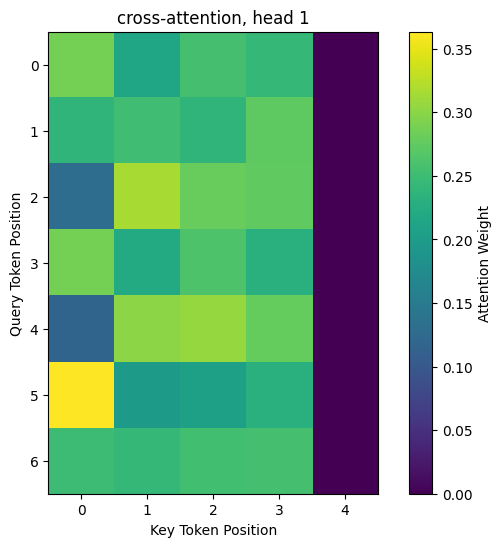

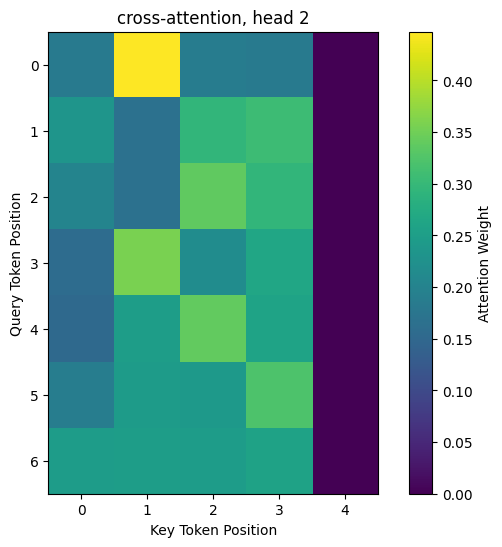

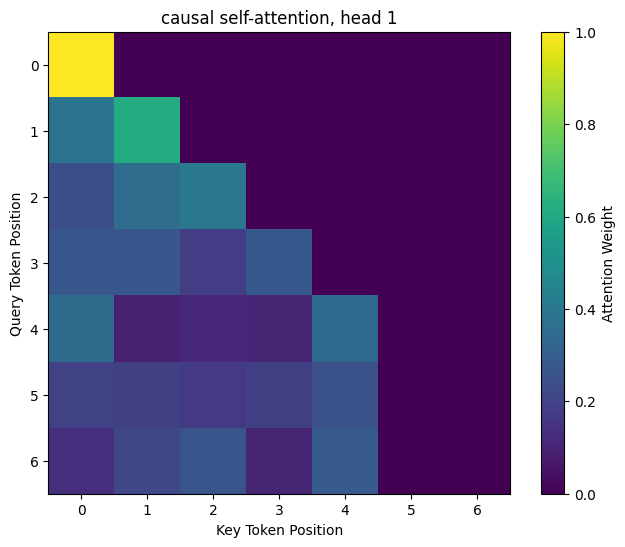

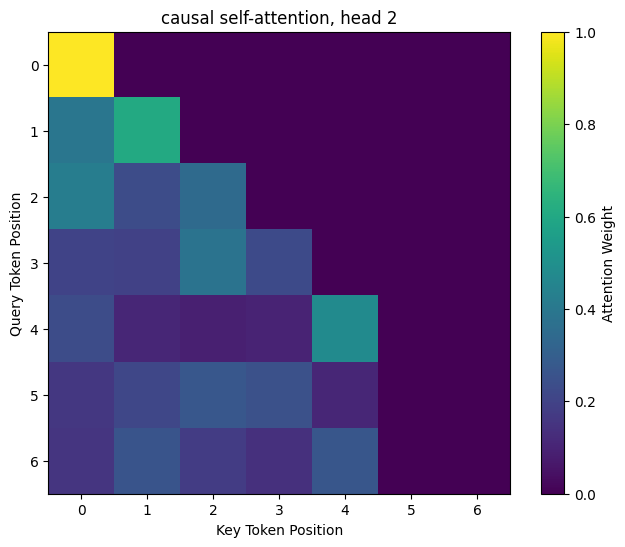

In [38]:
import torch
import matplotlib.pyplot as plt

embed_dim = 8
num_heads = 2
batch_size = 1
encoder_seq_length = 5
decoder_seq_length = 7

encoder_outputs = torch.randn(batch_size, encoder_seq_length, embed_dim)
decoder_inputs = torch.randn(batch_size, decoder_seq_length, embed_dim)

encoder_padding_mask = torch.zeros(batch_size, encoder_seq_length, dtype=torch.bool)
encoder_padding_mask[:, -1] = True

decoder_padding_mask = torch.zeros(batch_size, decoder_seq_length, dtype=torch.bool)
decoder_padding_mask[:, -2:] = True

cross_attention = MultiHeadAttention(embed_dim, num_heads, is_cross_attention=True)
causal_attention = MultiHeadAttention(embed_dim, num_heads, is_causal_attention=True)

cross_attention_out, cross_attention_weights = cross_attention(decoder_inputs, encoder_padding_mask, encoder_outputs)
causal_attention_out, causal_attention_weights = causal_attention(decoder_inputs, decoder_padding_mask)

assert cross_attention_out.shape == (batch_size, decoder_seq_length, embed_dim)
assert cross_attention_weights.shape == (batch_size, num_heads, decoder_seq_length, encoder_seq_length)
assert causal_attention_out.shape == (batch_size, decoder_seq_length, embed_dim)
assert causal_attention_weights.shape == (batch_size, num_heads, decoder_seq_length, decoder_seq_length)

assert torch.isclose(cross_attention_weights.sum(dim=-1), torch.tensor(1.0)).all()
assert torch.isclose(causal_attention_weights.sum(dim=-1), torch.tensor(1.0)).all()

assert torch.isclose(cross_attention_weights[:,:,:,-1], torch.tensor(0.0)).all()
assert torch.isclose(causal_attention_weights[:,:,:,-2:], torch.tensor(0.0)).all()
assert torch.isclose(causal_attention_weights[:,:,2,3:], torch.tensor(0.0)).all()

def plot_attention_matrix(attention_matrix, title):
    plt.figure(figsize=(8, 6))
    plt.imshow(attention_matrix, cmap='viridis', interpolation='nearest')
    plt.colorbar(label='Attention Weight')
    plt.xlabel('Key Token Position')
    plt.ylabel('Query Token Position')
    plt.title(title)
    plt.show()

plot_attention_matrix(cross_attention_weights[0,0].detach().numpy(), "cross-attention, head 1")
plot_attention_matrix(cross_attention_weights[0,1].detach().numpy(), "cross-attention, head 2")
plot_attention_matrix(causal_attention_weights[0,0].detach().numpy(), "causal self-attention, head 1")
plot_attention_matrix(causal_attention_weights[0,1].detach().numpy(), "causal self-attention, head 2")

In [39]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TransformerEmbeddings(nn.Module):
    def __init__(self, vocab_size: int, hidden_size: int, max_sequence_length: int):
        super().__init__()
        self.token_embeddings = nn.Embedding(vocab_size, hidden_size)
        self.position_embeddings = nn.Embedding(max_sequence_length, hidden_size)

    def compute_logits(self, decoder_output: torch.FloatTensor) -> torch.FloatTensor:
        return F.linear(decoder_output, self.token_embeddings.weight)

    def forward(self, input_ids: torch.LongTensor) -> torch.FloatTensor:
        batch_size, seq_len = input_ids.size()
        positions = torch.arange(seq_len, device=input_ids.device).unsqueeze(0).expand(batch_size, seq_len)
        token_embeds = self.token_embeddings(input_ids)
        position_embeds = self.position_embeddings(positions)
        return token_embeds + position_embeds

In [ ]:
class TransformerBlock(nn.Module):
    def __init__(self,
                 hidden_size: int,
                 intermediate_size: int,
                 num_attention_heads: int,
                 hidden_dropout_prob: float,
                 is_decoder: bool = False):
        super().__init__()

        self.is_decoder = is_decoder
        self.self_attention = MultiHeadAttention(hidden_size, num_attention_heads, is_causal_attention=is_decoder)
        self.self_attention_layer_norm = nn.LayerNorm(hidden_size)

        if is_decoder:
            self.cross_attention = MultiHeadAttention(hidden_size, num_attention_heads, is_cross_attention=True)
            self.cross_attention_layer_norm = nn.LayerNorm(hidden_size)

        self.feedforward = nn.Sequential(
            nn.Linear(hidden_size, intermediate_size),
            nn.ReLU(),
            nn.Linear(intermediate_size, hidden_size),
            nn.Dropout(hidden_dropout_prob))
        self.feedforward_layer_norm = nn.LayerNorm(hidden_size)

    def forward(self,
                hidden_states: torch.FloatTensor,
                padding_mask: torch.BoolTensor,
                encoder_outputs: Optional[torch.FloatTensor] = None,
                encoder_padding_mask: Optional[torch.BoolTensor] = None) -> torch.FloatTensor:
        hidden_states = self.self_attention(hidden_states, padding_mask)[0] + hidden_states
        hidden_states = self.self_attention_layer_norm(hidden_states)

        if self.is_decoder:
            hidden_states = self.cross_attention(hidden_states, encoder_padding_mask, encoder_outputs)[0] + hidden_states
            hidden_states = self.cross_attention_layer_norm(hidden_states)

        hidden_states = self.feedforward(hidden_states) + hidden_states
        hidden_states = self.feedforward_layer_norm(hidden_states)
        return hidden_states

In [41]:
import torch
import torch.nn as nn

class EncoderDecoderModel(nn.Module):
    def __init__(self,
                 source_vocab_size: int,
                 target_vocab_size: int,
                 hidden_size: int,
                 intermediate_size: int,
                 num_attention_heads: int,
                 num_encoder_layers: int,
                 num_decoder_layers: int,
                 max_sequence_length: int,
                 hidden_dropout_prob: float):
        super().__init__()
        self.encoder_embeddings = TransformerEmbeddings(source_vocab_size, hidden_size, max_sequence_length)
        self.decoder_embeddings = TransformerEmbeddings(target_vocab_size, hidden_size, max_sequence_length)
    
        self.encoder_blocks = nn.ModuleList([
            TransformerBlock(hidden_size, intermediate_size, num_attention_heads, hidden_dropout_prob, is_decoder=False)
            for _ in range(num_encoder_layers)
        ])
        self.decoder_blocks = nn.ModuleList([
            TransformerBlock(hidden_size, intermediate_size, num_attention_heads, hidden_dropout_prob, is_decoder=True)
            for _ in range(num_decoder_layers)
        ])

    def forward_encoder(self, input_ids: torch.LongTensor, padding_mask: torch.BoolTensor) -> torch.FloatTensor:
        hidden_states = self.encoder_embeddings(input_ids)
        for block in self.encoder_blocks:
            hidden_states = block(hidden_states, padding_mask)
        return hidden_states

    def forward_decoder(self,
                        input_ids: torch.LongTensor,
                        padding_mask: torch.BoolTensor,
                        encoder_outputs: torch.FloatTensor,
                        encoder_padding_mask: torch.BoolTensor) -> torch.FloatTensor:
        hidden_states = self.decoder_embeddings(input_ids)
        for block in self.decoder_blocks:
            hidden_states = block(hidden_states, padding_mask, encoder_outputs, encoder_padding_mask)
        logits = self.decoder_embeddings.compute_logits(hidden_states)
        return logits

    def forward(self, encoder_input_ids, encoder_padding_mask, decoder_input_ids, decoder_padding_mask):
        encoder_outputs = self.forward_encoder(encoder_input_ids, encoder_padding_mask)
        decoder_logits = self.forward_decoder(decoder_input_ids, decoder_padding_mask, encoder_outputs, encoder_padding_mask)
        return decoder_logits

## Train the model

In [42]:
def collate_fn(examples: List[Dict[str, List[int]]]) -> Dict[str, torch.Tensor]:
    """Collates a list of variable length sequences from the dataset into a batch of pytorch tensors with padding."""

    encoder_sequence_length = max(len(example["encoder_input_ids"]) for example in examples)
    decoder_sequence_length = max(len(example["decoder_input_ids"]) for example in examples)
    batch_size = len(examples)

    encoder_input_ids = torch.full((batch_size, encoder_sequence_length),
                                   fill_value=source_tokenizer.pad_token_id,
                                   dtype=torch.int64)
    encoder_padding_mask = torch.ones((batch_size, encoder_sequence_length),
                                      dtype=torch.bool)

    decoder_input_ids = torch.full((batch_size, decoder_sequence_length),
                                   fill_value=target_tokenizer.pad_token_id,
                                   dtype=torch.int64)
    decoder_padding_mask = torch.ones((batch_size, decoder_sequence_length),
                                      dtype=torch.bool)

    for i, example in enumerate(examples):
        encoder_input_ids[i, :len(example["encoder_input_ids"])] = torch.tensor(example["encoder_input_ids"])
        encoder_padding_mask[i, :len(example["encoder_input_ids"])] = False

        decoder_input_ids[i, :len(example["decoder_input_ids"])] = torch.tensor(example["decoder_input_ids"])
        decoder_padding_mask[i, :len(example["decoder_input_ids"])] = False

    return {"encoder_input_ids": encoder_input_ids,
            "encoder_padding_mask": encoder_padding_mask,
            "decoder_input_ids": decoder_input_ids,
            "decoder_padding_mask": decoder_padding_mask}

Simple training loop.

In [43]:
import time
import math

def compute_loss_per_token(model, batch):
    logits = model(**batch)

    valid_label_mask = ~(batch["decoder_padding_mask"][:,1:])
    labels = batch["decoder_input_ids"][:,1:][valid_label_mask]
    logits = logits[:,:-1][valid_label_mask]

    return F.cross_entropy(logits, labels, reduction='none')

def evaluate_perplexity(model, dataset, batch_size=16, device="cpu"):
    model.eval()

    dev_loader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

    num_tokens = loss_sum = 0

    with torch.no_grad():
        for batch in dev_loader:
            for key in batch:
                batch[key] = batch[key].to(device)

            token_losses = compute_loss_per_token(model, batch)

            loss_sum += token_losses.sum()
            num_tokens += token_losses.numel()

        dev_ppl = (loss_sum / num_tokens).exp().cpu().item()
    return dev_ppl

def train(model, training_dataset, validation_dataset,
          batch_size=16, lr=5e-4, max_epoch=15, log_every=10, valid_niter=100,
          model_path="model.pt", patience=3):
    model.train()

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print('Use device: %s' % device)

    model = model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    epoch = global_step = loss_sum = num_tokens = num_examples = 0
    best_valid_perplexity = float('inf')
    epochs_without_improvement = 0
    train_time = begin_time = time.time()
    print('Beginning maximum likelihood training')

    while True:
        train_loader = torch.utils.data.DataLoader(
            training_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
        epoch += 1
        batches_per_epoch = len(train_loader)
        for i, batch in enumerate(train_loader):
            global_step += 1

            for key in batch:
                batch[key] = batch[key].to(device)

            optimizer.zero_grad()

            token_losses = compute_loss_per_token(model, batch)
            total_loss = token_losses.sum()

            loss = total_loss / batch_size
            loss.backward()

            optimizer.step()

            loss_sum += total_loss.cpu().item()
            num_tokens += token_losses.numel()
            num_examples += batch_size

            if global_step % log_every == 0:
                average_loss = loss_sum / num_examples
                average_ppl = math.exp(loss_sum / num_tokens)
                print(f"epoch {epoch} ({i}/{batches_per_epoch}) | step {global_step} | "
                      f"avg_nll={average_loss:.2f} avg_ppl={average_ppl:.2f} "
                      f"speed={num_tokens / (time.time() - train_time):.2f} words/sec "
                      f"time_elapsed={time.time() - begin_time:.2f} sec")

                train_time = time.time()
                loss_sum = num_tokens = num_examples = 0.0

            if global_step % valid_niter == 0:
                print('Begin validation ...')
                dev_perplexity = evaluate_perplexity(model, validation_dataset, batch_size=batch_size, device=device)

                print(f"validation: step {global_step} | dev_ppl={dev_perplexity}")

                if dev_perplexity < best_valid_perplexity:
                    best_valid_perplexity = dev_perplexity
                    epochs_without_improvement = 0
                    print(f"epoch {epoch} step {global_step}: save currently the best model to '{model_path}'")
                    torch.save(model.state_dict(), model_path)
                    torch.save(optimizer.state_dict(), model_path + '.optim')
                else:
                    epochs_without_improvement += 1
                    if epochs_without_improvement >= patience:
                        print(f"No improvement in validation perplexity for {patience} checks. Stopping early.")
                        return

                model.train()

        if epoch == max_epoch:
            print('Reached maximum number of epochs')
            break

In [44]:
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

model = EncoderDecoderModel(
    source_vocab_size=source_tokenizer.vocab_size,
    target_vocab_size=target_tokenizer.vocab_size,
    hidden_size=128,
    intermediate_size=128 * 4,
    num_attention_heads=4,
    num_encoder_layers=4,
    num_decoder_layers=4,
    max_sequence_length=32,
    hidden_dropout_prob=0.1,
)

print("Model architecture:", model)
print("Total number of trainable model parameters:", sum(p.numel() for p in model.parameters() if p.requires_grad))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print("Model device:", next(model.parameters()).device)

train(model, tokenized_datasets["train"], tokenized_datasets["validation"],
      max_epoch=20, batch_size=8, lr=5e-4, model_path="model.pt")

Model architecture: EncoderDecoderModel(
  (encoder_embeddings): TransformerEmbeddings(
    (token_embeddings): Embedding(119547, 128)
    (position_embeddings): Embedding(32, 128)
  )
  (decoder_embeddings): TransformerEmbeddings(
    (token_embeddings): Embedding(119547, 128)
    (position_embeddings): Embedding(32, 128)
  )
  (encoder_blocks): ModuleList(
    (0-3): 4 x TransformerBlock(
      (self_attention): MultiHeadAttention(
        (query_projection): Linear(in_features=128, out_features=128, bias=True)
        (key_projection): Linear(in_features=128, out_features=128, bias=True)
        (value_projection): Linear(in_features=128, out_features=128, bias=True)
        (output_projection): Linear(in_features=128, out_features=128, bias=True)
      )
      (self_attention_layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (feedforward): Sequential(
        (0): Linear(in_features=128, out_features=512, bias=True)
        (1): ReLU()
        (2): Linear(in_

## Evaluate the model

In [45]:
from tqdm import tqdm
from nltk.translate.bleu_score import corpus_bleu

def beam_search(model: EncoderDecoderModel,
                encoder_input_ids: torch.LongTensor,
                beam_width: int = 5,
                max_len: int = 32,
                length_penalty: float = 1.0,
                diversity_penalty: float = 0.5) -> Tuple[torch.LongTensor, float]:
    model.eval()

    encoder_input_ids = encoder_input_ids.unsqueeze(0)
    encoder_padding_mask = torch.zeros_like(encoder_input_ids, dtype=torch.bool)
    encoder_outputs = model.forward_encoder(encoder_input_ids, encoder_padding_mask)

    generations = [torch.tensor([target_tokenizer.cls_token_id], device=encoder_input_ids.device)]
    scores = [0.0]

    best_generation = None
    best_score = float('-inf')

    for _ in range(max_len):
        new_generations = []
        new_scores = []
        for score, generation in zip(scores, generations):
            generation = generation.unsqueeze(0)
            padding_mask = torch.zeros_like(generation, dtype=torch.bool)
            decoder_output = model.forward_decoder(generation, padding_mask, encoder_outputs, encoder_padding_mask)
            last_log_probs = decoder_output[0, -1, :].log_softmax(dim=-1)
            top_log_probs, top_indices = last_log_probs.topk(beam_width, dim=-1)

            new_generations.append(torch.cat([generation.expand(beam_width, -1), top_indices[:,None]], dim=1))
            new_scores.append(score + top_log_probs - diversity_penalty * torch.arange(beam_width, device=top_log_probs.device, dtype=torch.float))

        new_generations = torch.cat(new_generations, dim=0)
        new_scores = torch.cat(new_scores, dim=0)

        ends_with_eos = target_tokenizer.sep_token_id == new_generations[:,-1]

        if ends_with_eos.any():
            new_completed_generations = new_generations[ends_with_eos]
            new_completed_scores = new_scores[ends_with_eos]
            for gen, sc in zip(new_completed_generations, new_completed_scores):
                length = len(gen) - 1
                normalized_score = sc * (length ** length_penalty)
                if normalized_score > best_score:
                    best_score = normalized_score
                    best_generation = gen

        if best_score >= new_scores.max() * (len(new_generations[0]) ** length_penalty):
            break

        scores, indices = torch.topk(new_scores, beam_width, dim=-1)
        generations = new_generations[indices]

    if best_generation is None:
        best_generation = generations[0]
        best_score = scores[0] * (len(generations[0]) ** length_penalty)

    return best_generation, best_score.cpu().item()

def run_generation(model, test_dataset, beam_size=5, max_decoding_time_step=32):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print('Use device: %s' % device)

    input_sentences = []
    reference_sentences = []
    candidate_sentences = []

    with torch.no_grad():
        for example in tqdm(test_dataset):
            encoder_input_ids = torch.tensor(example["encoder_input_ids"], device=device)

            generation, _ = beam_search(model, encoder_input_ids, beam_size, max_decoding_time_step, length_penalty=1.0, diversity_penalty=0.5)

            input_text = source_tokenizer.decode(example["encoder_input_ids"][1:-1], skip_special_tokens=True)
            reference_text = target_tokenizer.decode(example["decoder_input_ids"][1:-1], skip_special_tokens=True)
            candidate_text = target_tokenizer.decode(generation[1:-1].cpu(), skip_special_tokens=True)

            reference_sentences.append(reference_text)
            candidate_sentences.append(candidate_text)
            input_sentences.append(input_text)

    bleu_score = corpus_bleu([[ref] for ref in reference_sentences],
                             [candidate for candidate in candidate_sentences])

    return bleu_score, input_sentences, reference_sentences, candidate_sentences

In [46]:
# Restore the best validation checkpoint
model.load_state_dict(torch.load("model.pt"))

bleu_score, inputs, references, candidates = run_generation(model, tokenized_datasets["test"])
print('\n\nCorpus BLEU: {}'.format(bleu_score * 100))

Use device: cpu


100%|██████████| 3717/3717 [43:05<00:00,  1.44it/s]  




Corpus BLEU: 20.017412021227518


Let's look at some examples. What do you think of the quality of the translations?

In [ ]:
for k in range(1, 20):
  print(f"===== Sample {k} =====")
  print(f"Input: {inputs[k]}")
  print(f"Gold: {references[k]}")
  print(f"Pred: {candidates[k]}")

===== Sample 1 =====
Input: average age is year old.
Gold: متوسط اعمارهم عاما ؛
Pred: مدونة
===== Sample 2 =====
Input: intercontinental cry has a list of recommended films on indigenous issues some made by indigenous people from brazil australia panama usa northern
Gold: ينشر موقع انترناشيونال كراي او صرخة دولية قايمة تحتوي فيلم ينصح بهم يغط
Pred: المدون انكليزي اكثر من اكثر من اكثر من اكثر من اكثر من المكس
===== Sample 3 =====
Input: We don ' t know him.
Gold: نحن لا نعرفه.
Pred: لا نعرفه.
===== Sample 4 =====
Input: lebanon blogging the elections global voices.
Gold: لبنان التدوين عن الانتخابات الاصوات العالمية
Pred: لبنان المدون الاصوات العالمية
===== Sample 5 =====
Input: Tom quit.
Gold: توم استقال.
Pred: توم أخير.
===== Sample 6 =====
Input: Tom always has a smile on his face.
Gold: الابتسامة لا تفارق وجه توم.
Pred: توم دائما دائماً.
===== Sample 7 =====
Input: My father works in a factory.
Gold: يعمل أبي في مصنع.
Pred: ربما ماريئاً.
===== Sample 8 =====
Input: on may and activis